In [12]:
import numpy as np
import pymc as pm

count_data = np.loadtxt('Chapter1_Introduction/data/txtdata.csv')
n_count_data = len(count_data)
alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper= n_count_data)

print "Random output of tau:", tau.random(), tau.random(), tau.random()

 Random output of tau: 35 63 14


In [14]:
#although this is a stochastic function PyMC uses this @pm.deterministic 
#as a decorator
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    """
    Generates a random variable lambda based on value of tau
    """
    output = np.zeros(n_count_data)
    output[:tau] = lambda_1 #lambda before event tau is lambda_1
    output[tau:] = lambda_2 #lambda after evetnt tau is lambda_2
    return output



In [16]:
observation = pm.Poisson('obs', lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [17]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 9.7 sec

In [28]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

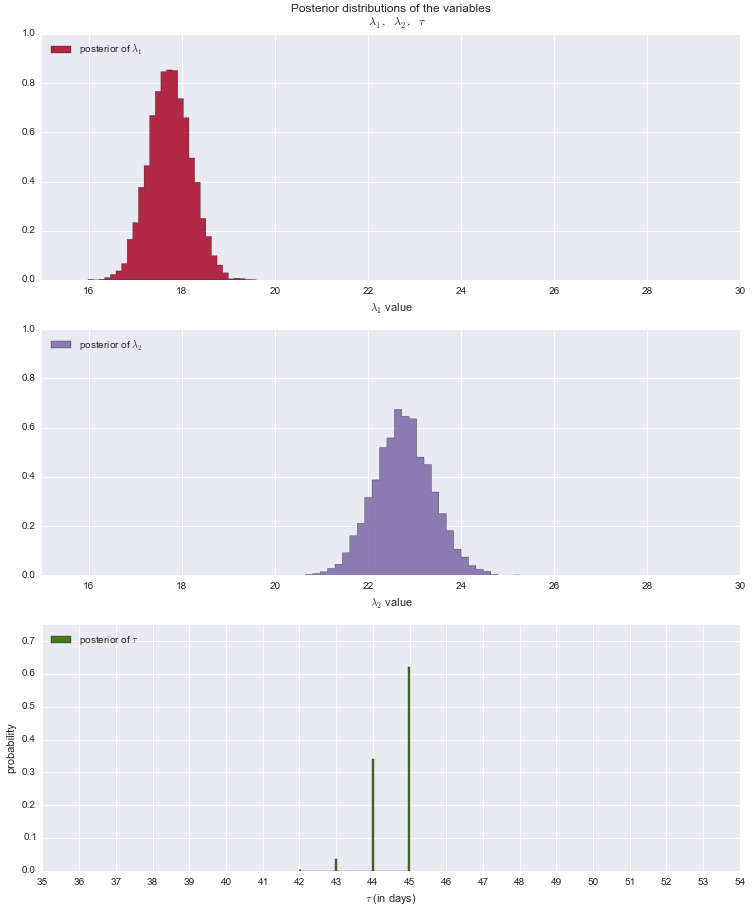

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

from pylab import rcParams
rcParams['figure.figsize'] = 12.5, 15

#figure(figsize(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

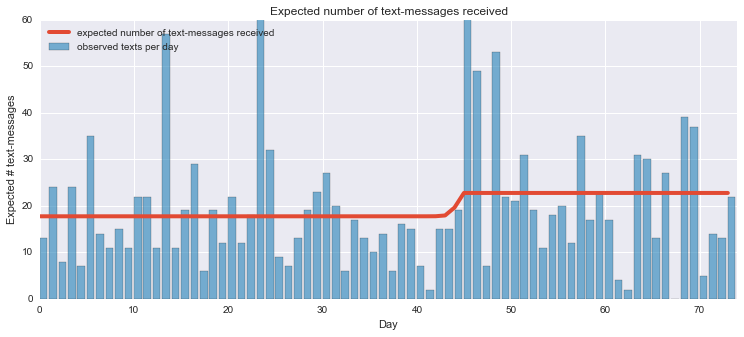

In [40]:
rcParams['figure.figsize'] = 12.5, 5

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    
    ix = day < tau_samples
    #to estimate the number of texts per day we need to estimate the paramter
    #lambda. We've assumed the text counts are similar to a Poisson distribution
    #We said that lambda is dependent upon a variable tau
    #to determine which regime we are in lambda1 or lambda2 we 
    #can check which day we are in and ad up the expected values of Lambda for that 
    #day and get an expected message count
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() +
                                   lambda_2_samples[~ix].sum()) / N
    
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");